## GMU gates analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
gates = np.load('model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run/gates.npy')

In [3]:
gates.shape

(987, 3840)

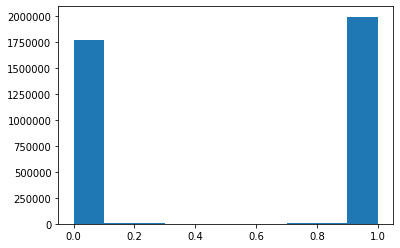

In [4]:
plt.hist(np.ravel(gates))
plt.show()

#### Text

In [5]:
txt_gates = gates[:, :768]

In [6]:
np.mean(np.mean(txt_gates, axis=0))

0.53641474

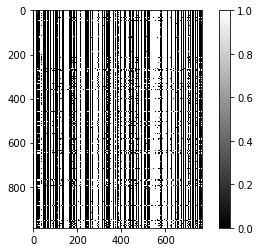

In [7]:
#fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(txt_gates, cmap='gray')
plt.colorbar()
plt.show()

#### Video

In [8]:
vid_gates = gates[:, 768:768*2]

In [9]:
np.mean(np.mean(vid_gates, axis=0))

0.54050523

#### Audio

In [10]:
audio_gates = gates[:, 768*2:768*3]

In [11]:
np.mean(np.mean(audio_gates, axis=0))

0.51183224

#### Image

In [12]:
img_gates = gates[:, 768*3:768*4]

In [13]:
np.mean(np.mean(img_gates, axis=0))

0.536018

#### Metadata

In [14]:
meta_gates = gates[:, 768*4:]

In [15]:
np.mean(np.mean(meta_gates, axis=0))

0.5258729

### Stack predictions of each modality in new axis

In [16]:
all_gates = np.stack([txt_gates, vid_gates, audio_gates, img_gates, meta_gates], axis=1)

In [17]:
all_gates.shape

(987, 5, 768)

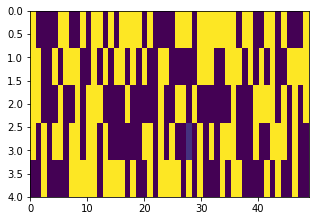

In [18]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

limit = 50
img = plt.imshow(all_gates[0,:,:limit], extent=[0,limit-1,all_gates.shape[1]-1,0])
forceAspect(ax, aspect=1.5)

### Max activation per modality
Get index of modality with maximum value for each dimension:

* max_activation[i,j] $\in \{0,1,2,3,4\}$ for $i = 1,2, ..., N$ and $j = 1,2, ..., 768$

In [19]:
max_activation = np.argmax(all_gates, axis=1)

In [20]:
max_activation.shape

(987, 768)

#### Get frequencies of modality index for each test example (1,2, ..., N)

In [21]:
modality_count = list(map(np.bincount, max_activation))
modality_count = np.array(modality_count)

In [22]:
modality_count.shape

(987, 5)

In [23]:
modality_count[:10]

array([[424, 187,  85,  50,  22],
       [409, 187,  91,  55,  26],
       [424, 187,  85,  50,  22],
       [420, 187,  86,  53,  22],
       [420, 193,  85,  46,  24],
       [423, 185,  86,  50,  24],
       [414, 188,  86,  54,  26],
       [421, 187,  86,  52,  22],
       [423, 186,  86,  51,  22],
       [421, 187,  85,  53,  22]])

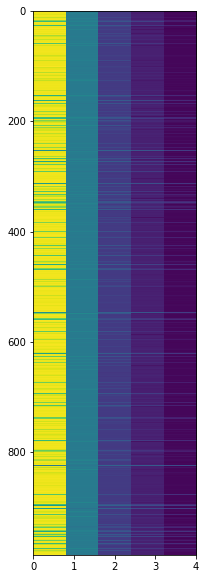

In [24]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(modality_count, extent=[0,4,modality_count.shape[0]-1,0])
forceAspect(ax, aspect=0.3)

In [ ]:
#fig, ax = plt.subplots(figsize=(1, 100))
plt.figure(figsize = (1,100))
plt.imshow(modality_count[:100])
plt.show()

### Frequencies of modality's activation > threshold

In [26]:
from collections import Counter

modality_dist = []
threshold = 0.9

for i in range(all_gates.shape[0]):
    example_modality_freq = []
    for j in range(all_gates.shape[1]):
        modality_true_counts = Counter(all_gates[i][j] > threshold)[True]
        example_modality_freq.append(modality_true_counts)
    modality_dist.append(np.array(example_modality_freq))

modality_dist = np.array(modality_dist)

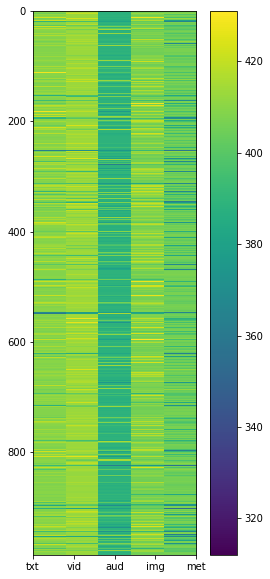

In [27]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(modality_dist, extent=[0,4,modality_dist.shape[0]-1,0])
forceAspect(ax, aspect=0.3)
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_xticklabels(modality_xticks);

In [28]:
#activation_rate = np.sum(modality_dist, axis=0)/np.sum(np.sum(modality_dist, axis=0))
activation_mean = np.mean(modality_dist, axis=0)
activation_std = np.std(modality_dist, axis=0)
print(f"plot: {activation_mean[0]:.1f}±{activation_std[0]:.1f}\
    \nvid: {activation_mean[1]:.1f}±{activation_std[1]:.1f}\
    \naud: {activation_mean[2]:.1f}±{activation_std[2]:.1f}\
    \nimg: {activation_mean[3]:.1f}±{activation_std[3]:.1f}\
    \nmet: {activation_mean[4]:.1f}±{activation_std[4]:.1f}")

plot: 409.5±6.6    
vid: 412.4±5.9    
aud: 390.5±7.6    
img: 408.8±6.2    
met: 401.1±9.9


<BarContainer object of 5 artists>

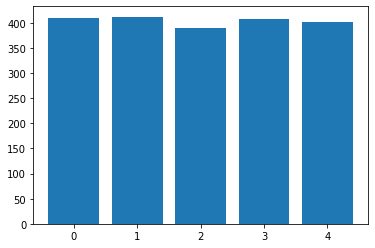

In [29]:
plt.bar(np.arange(len(activation_mean)), activation_mean)

### Frequencies of modality's activation > threshold for correct predicitons

In [30]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

In [31]:
model_preds = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_gold.txt")
ground_truth_labels = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_pred.txt")

In [32]:
preds_equal_eval = list(map(np.all, np.equal(model_preds, ground_truth_labels)))
preds_equal_eval = np.array(preds_equal_eval)

In [33]:
correct_indexes = np.argwhere(preds_equal_eval == True)
correct_indexes = np.squeeze(correct_indexes, axis=1)

Mean number of labels per example for all test examples

In [34]:
examples_num_genres = []

for i in range(ground_truth_labels.shape[0]):
    genres_count = len(np.argwhere(ground_truth_labels[i] == 1).flatten())
    examples_num_genres.append(genres_count)
    
print(f'mean num labels: {np.mean(examples_num_genres)}')
print(f'std dev num lables: {np.std(examples_num_genres)}')

mean num labels: 2.7041540020263426
std dev num lables: 1.0745338842874883


Mean number of labels per example for correctly predicted test examples

In [35]:
examples_num_genres = []

for i in range(correct_indexes.shape[0]):
    genres_count = len(np.argwhere(ground_truth_labels[correct_indexes][i] == 1).flatten())
    examples_num_genres.append(genres_count)
    
print(f'mean num labels: {np.mean(examples_num_genres)}')
print(f'std dev num lables: {np.std(examples_num_genres)}')

mean num labels: 2.2145922746781115
std dev num lables: 0.9567254288490579


Select modality counts for correctly predicted examples

In [36]:
correct_modality_dist = modality_dist[correct_indexes]

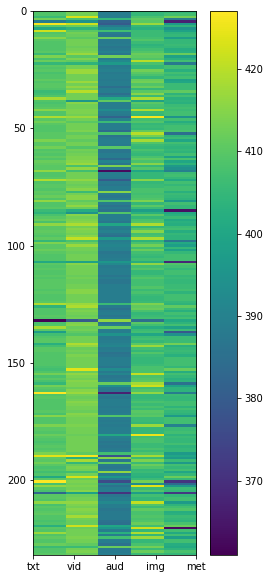

In [37]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(correct_modality_dist, extent=[0,4,correct_modality_dist.shape[0]-1,0])
forceAspect(ax, aspect=0.3)
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_xticklabels(modality_xticks);

In [38]:
activation_mean = np.mean(correct_modality_dist, axis=0)
activation_std = np.std(correct_modality_dist, axis=0)
print(f"plot: {activation_mean[0]:.1f}±{activation_std[0]:.1f}\
    \nvid: {activation_mean[1]:.1f}±{activation_std[1]:.1f}\
    \naud: {activation_mean[2]:.1f}±{activation_std[2]:.1f}\
    \nimg: {activation_mean[3]:.1f}±{activation_std[3]:.1f}\
    \nmet: {activation_mean[4]:.1f}±{activation_std[4]:.1f}")

plot: 409.6±5.3    
vid: 412.8±4.4    
aud: 390.6±7.7    
img: 408.4±5.0    
met: 402.9±7.6


<BarContainer object of 5 artists>

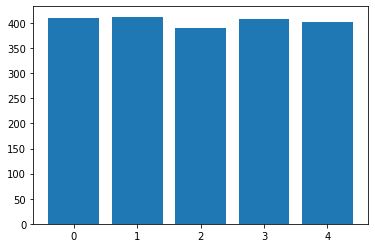

In [39]:
plt.bar(np.arange(len(activation_mean)), activation_mean)

### Frequencies of modality's activation > threshold for a specific genre

In [40]:
with open("model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run/test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")

ground_truth_labels = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_pred.txt")

In [41]:
label_names

['Mystery',
 'Thriller',
 'Comedy',
 'Action',
 'Crime',
 'Drama',
 'Family',
 'Horror',
 'Biography',
 'Romance',
 'Sci-Fi',
 'Fantasy',
 'Animation']

In [42]:
genre = 'Horror'
genre_idx = label_names.index(genre)

genre_examples_idx = np.argwhere((ground_truth_labels[:, genre_idx] == 1) == True)
genre_examples_idx = np.squeeze(genre_examples_idx, axis=1)

genre_modality_dist = modality_dist[genre_examples_idx]

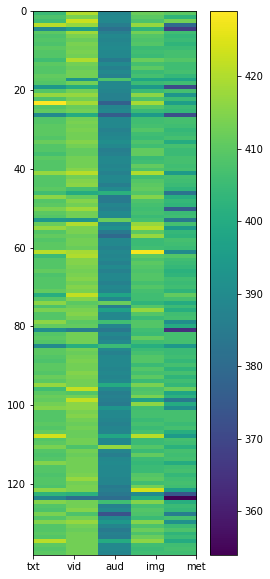

In [43]:
def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    plt.colorbar()

fig = plt.figure()
fig.set_size_inches(5,10)
ax = fig.add_subplot(111)

img = plt.imshow(genre_modality_dist, extent=[0,4,genre_modality_dist.shape[0]-1,0])
forceAspect(ax, aspect=0.3)
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_xticklabels(modality_xticks);

In [44]:
activation_mean = np.mean(genre_modality_dist, axis=0)
activation_std = np.std(genre_modality_dist, axis=0)
print(f"plot: {activation_mean[0]:.1f}±{activation_std[0]:.1f}\
    \nvid: {activation_mean[1]:.1f}±{activation_std[1]:.1f}\
    \naud: {activation_mean[2]:.1f}±{activation_std[2]:.1f}\
    \nimg: {activation_mean[3]:.1f}±{activation_std[3]:.1f}\
    \nmet: {activation_mean[4]:.1f}±{activation_std[4]:.1f}")

plot: 409.4±5.6    
vid: 412.6±5.8    
aud: 389.3±5.9    
img: 408.3±5.1    
met: 401.6±9.6


#### Heatmap modality normalized

In [45]:
genre_rates = np.zeros((13, 5))

for i, lable in enumerate(label_names):
    # get genre position
    genre_idx = label_names.index(lable)

    # Filter test examples that include that genre
    genre_examples_idx = np.argwhere((ground_truth_labels[:, genre_idx] == 1) == True)
    genre_examples_idx = np.squeeze(genre_examples_idx, axis=1)
    genre_modality_dist = modality_dist[genre_examples_idx]
    
    # Compute proportion of activations per modality
    #total_mod = np.sum(genre_modality_dist, axis=0)
    #genre_rates[i] = total_mod/np.sum(total_mod)
    genre_rates[i] = np.mean(genre_modality_dist, axis=0)

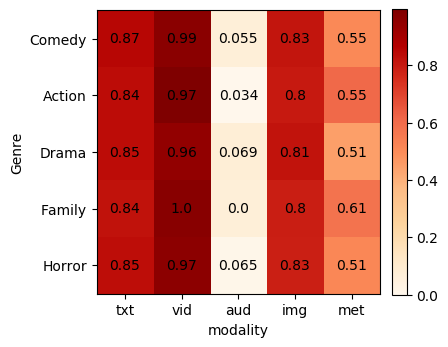

In [94]:
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('default')

def forceAspect(ax,aspect):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)
    #plt.colorbar()

fig = plt.figure()
#fig.set_size_inches(5,10)
fig.set_size_inches(4,5)
ax = fig.add_subplot(111)

selected_idxs = [2,3,5,6,7]
#selected_idxs = [i for i in range(len(label_names))]
selected_label_names = [label_names[idx] for idx in selected_idxs]
genre_rates_norm = (genre_rates-np.min(genre_rates))/(np.max(genre_rates)-np.min(genre_rates))

img = plt.imshow(genre_rates_norm[selected_idxs], extent=[0,4,genre_rates_norm[selected_idxs].shape[0]-1,0], cmap='OrRd')
#forceAspect(ax, aspect=0.5)
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_xticklabels(modality_xticks);
plt.yticks(range(len(selected_label_names)), selected_label_names);
ax.set_xticks([0.4, 1.2, 2, 2.8, 3.6])
ax.set_yticks([0.4, 1.2, 2, 2.8, 3.6])
ax.set_xlabel('modality');
ax.set_ylabel('Genre');
plt.colorbar(img, fraction=0.046, pad=0.04);

'''
Place values inside cell
'''

# Limits for the extent
size=5
x_start = 0.
x_end = 4.0
y_start = 0.
y_end = 4.0

extent = [x_start, x_end, y_start, y_end]

# Add the text
jump_x = (x_end - x_start) / (2.0 * size)
jump_y = (y_end - y_start) / (2.0 * size)
x_positions = np.linspace(start=x_start, stop=x_end, num=size, endpoint=False)
y_positions = np.linspace(start=y_start, stop=y_end, num=size, endpoint=False)

for y_index, y in enumerate(y_positions):
    for x_index, x in enumerate(x_positions):
        label = genre_rates_norm[y_index, x_index]
        text_x = x + jump_x
        text_y = y + jump_y
        ax.text(text_x, text_y, f'{label:.2}', color='black', ha='center', va='center')


#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#plt.colorbar(img, cax=cax)

#clb = plt.colorbar();

#clb.ax.set_title('GMU activation')
#plt.savefig('GMU_activations.png', bbox_inches='tight')

### Get highest or lowest example index activatons per modality

In [44]:
import json
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

In [31]:
def get_extreme_index(modality_name, func, modality_dist):
    modality_txt2idx = {'txt': 0,'vid': 1,'aud': 2,'img': 3, 'met': 4}
    
    return func(modality_dist[:, modality_txt2idx[modality_name]])

#### Build dictionary from example_id to to test file row id

In [35]:
exampleid2row = {json.loads(line)['id']:i for i, line in enumerate(open('../moviescope/test.jsonl'))}

#### Load test predictions, labels and metadata

In [36]:
metadata_df = pd.read_csv('../moviescope/movie_metadata.csv')
data_labels = [json.loads(line) for line in open('../moviescope/test.jsonl')]

with open("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")
    
model_preds = load_labels("model_save_mmtr/moviescope_VideoTextPosterMetaGMUSeed5_mmtr_model_run/test_labels_pred.txt")

In [ ]:
metadata_df[metadata_df['genres'].str.contains("Action")]["movie_title"].iloc[:50]

### Get highest or lowest example index activatons per modality for correct predictions

### Audio

#### Get example where audio had the highest frequency

In [38]:
example_id = get_extreme_index("aud", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 3015,
 'synopsis': "The film closely follows Bly's original account, and extracts much of the dialogue from Bly’s 1880s expose Ten Days in a Mad-House. In an interview on Los Angeles talk radio, Caroline Barry recounts Christopher Lambert bringing authenticity to the part of the antagonist Dr. Dent, by portraying his motives as misguided good intent rather than evil. Which she feels adds to the realism of the biopic."}

In [39]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 66


In [40]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Timothy Hines
num_critic_for_reviews                                                       1
duration                                                                   111
director_facebook_likes                                                      0
actor_3_facebook_likes                                                     247
actor_2_name                                                     Kelly LeBrock
actor_1_facebook_likes                                                    1000
gross                                                                    14616
genres                                                                   Drama
actor_1_name                                               Christopher Lambert
movie_title                                             10 Days in a Madhouse 
num_voted_users                                     

In [41]:
model_label_preds = []

for i, value in enumerate(model_preds[correct_indexes[example_id]]):
    if value == 1:
        model_label_preds.append(label_names[i])
        
ground_truth_labels = metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']].genres.split('|')
        
print(f"Predicted labels: ", model_label_preds)
print(f"Ground truth labels: ", ground_truth_labels)

Predicted labels:  ['Drama']
Ground truth labels:  ['Drama']


In [42]:
correct_modality_dist[example_id]

array([361, 380, 416, 385, 401])

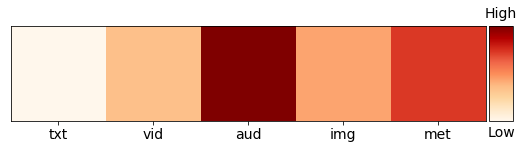

In [53]:
example_modality_dist = correct_modality_dist[example_id][np.newaxis, ...]/np.sum(correct_modality_dist[example_id])

fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.add_subplot(111)

img = plt.imshow(example_modality_dist, cmap='OrRd')
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_yticks([])
ax.set_xticks(np.arange(len(modality_xticks)))
plt.xticks(fontsize=14)
ax.set_xticklabels(modality_xticks);

# Adjust colorbar size to match figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
# Remove minor ticks in colorbar
cbar.set_ticks([])
# Add text labels at top and bottom of colorbar
cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
    va='top', ha='center', fontsize=14)
cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
    va='bottom', ha='center', fontsize=14);

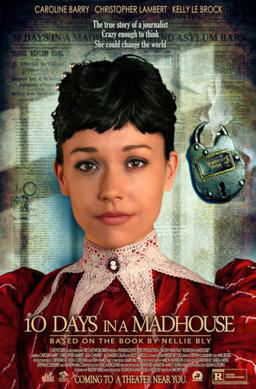

In [48]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

#### Get example where audio had the lowest frequency

In [54]:
example_id = get_extreme_index("aud", np.argmin, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 3957,
 'synopsis': 'The main character, a biologist named Victor Sluzhkin, loses his job and, to make ends meet, is forced to take a job in a local school as a geography teacher. His family has little money and lives in a dilapidated apartment in an old Soviet era building. His best friend is having an affair with his wife. The students in his class do not respect him and the assistant principal does not like his teaching methods. He feels lonely and depressed. To deal with the stresses of life, he drinks a lot. His alcohol-fueled binges provide a temporary respite, but no lasting comfort. When he organizes a trip on the river with a group of students from his class, it turns into a journey of self-discovery both for him and for the young men and women from his class.'}

In [55]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 139


In [56]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                            Aleksandr Veledinskiy
num_critic_for_reviews                                                       8
duration                                                                   120
director_facebook_likes                                                      0
actor_3_facebook_likes                                                      22
actor_2_name                                                     Elena Lyadova
actor_1_facebook_likes                                                     114
gross                                                                      NaN
genres                                                         Adventure|Drama
actor_1_name                                             Konstantin Khabenskiy
movie_title                               The Geographer Drank His Globe Away 
num_voted_users                                     

In [58]:
model_label_preds = []

for i, value in enumerate(model_preds[correct_indexes[example_id]]):
    if value == 1:
        model_label_preds.append(label_names[i])
        
ground_truth_labels = metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']].genres.split('|')
        
print(f"Predicted labels: ", model_label_preds)
print(f"Ground truth labels: ", ground_truth_labels)

Predicted labels:  ['Drama']
Ground truth labels:  ['Adventure', 'Drama']


In [57]:
correct_modality_dist[example_id]

array([416, 407, 363, 400, 390])

### Video

#### Get example where video had the highest frequency

In [59]:
example_id = get_extreme_index("vid", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 4161,
 'synopsis': "Fonda plays Ulee  Jackson, a Vietnam vet, widower and grandfather. He is a beekeeper by profession, who raises two granddaughters  because his son  is in prison and his daughter-in-law Helen , a drug addict, has run away. The son implores him to look for his wife and bring her home. Upon returning home with Helen, Ulee's granddaughters see their mother going through withdrawal, and plead with their neighbor Connie  to help her. Connie is a twice-divorced nurse who assists Ulee in getting his daughter-in-law through detox. The film shows Ulee holding the family together and attempting to protect them from two young criminals, associates of his son, who come looking for a hidden stash of cash."}

In [60]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 120


In [61]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                     Victor Nunez
num_critic_for_reviews                                                      61
duration                                                                   113
director_facebook_likes                                                      9
actor_3_facebook_likes                                                      42
actor_2_name                                               Patricia Richardson
actor_1_facebook_likes                                                     402
gross                                                              9.05474e+06
genres                                                                   Drama
actor_1_name                                                       Peter Fonda
movie_title                                                       Ulee's Gold 
num_voted_users                                     

In [62]:
correct_modality_dist[example_id]

array([424, 426, 378, 418, 400])

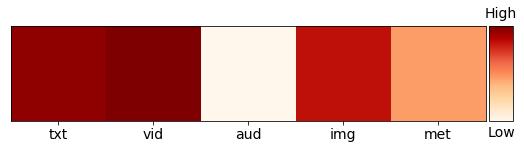

In [63]:
example_modality_dist = correct_modality_dist[example_id][np.newaxis, ...]/np.sum(correct_modality_dist[example_id])

fig = plt.figure()
fig.set_size_inches(9,9)
ax = fig.add_subplot(111)

img = plt.imshow(example_modality_dist, cmap='OrRd')
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_yticks([])
ax.set_xticks(np.arange(len(modality_xticks)))
plt.xticks(fontsize=14)
ax.set_xticklabels(modality_xticks);

# Adjust colorbar size to match figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
# Remove minor ticks in colorbar
cbar.set_ticks([])
# Add text labels at top and bottom of colorbar
cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
    va='top', ha='center', fontsize=14)
cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
    va='bottom', ha='center', fontsize=14);

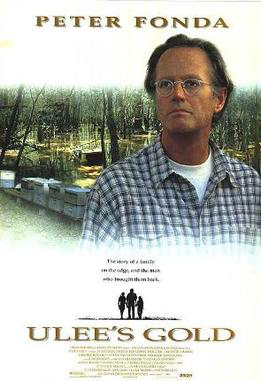

In [64]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

#### Get example where video had the lowest frequency

In [537]:
example_id = get_extreme_index("vid", np.argmin, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 3015,
 'synopsis': "The film closely follows Bly's original account, and extracts much of the dialogue from Bly’s 1880s expose Ten Days in a Mad-House. In an interview on Los Angeles talk radio, Caroline Barry recounts Christopher Lambert bringing authenticity to the part of the antagonist Dr. Dent, by portraying his motives as misguided good intent rather than evil. Which she feels adds to the realism of the biopic."}

In [538]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 66


In [539]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Timothy Hines
num_critic_for_reviews                                                       1
duration                                                                   111
director_facebook_likes                                                      0
actor_3_facebook_likes                                                     247
actor_2_name                                                     Kelly LeBrock
actor_1_facebook_likes                                                    1000
gross                                                                    14616
genres                                                                   Drama
actor_1_name                                               Christopher Lambert
movie_title                                             10 Days in a Madhouse 
num_voted_users                                     

In [540]:
correct_modality_dist[example_id]

array([361, 380, 416, 385, 401])

### Plot

#### Get example where plot had the max frequency

In [268]:
example_id = get_extreme_index("txt", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama', 'Romance'],
 'id': 3899,
 'synopsis': 'Crippled trapeze aerialist and former star Mike Ribble  sees great promise in young, brash Tino Orsini . Ribble—only the sixth man to have completed the dangerous triple somersault—thinks his protégé is capable, under his rigorous training, of matching his feat. However, Orsini is distracted by the third member of their circus act, the manipulative Lola . Tensions rise as a love triangle forms.'}

In [269]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 64


In [270]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                       Carol Reed
num_critic_for_reviews                                                      20
duration                                                                   105
director_facebook_likes                                                     82
actor_3_facebook_likes                                                      69
actor_2_name                                                       Katy Jurado
actor_1_facebook_likes                                                     746
gross                                                                      NaN
genres                                                           Drama|Romance
actor_1_name                                                 Gina Lollobrigida
movie_title                                                           Trapeze 
num_voted_users                                     

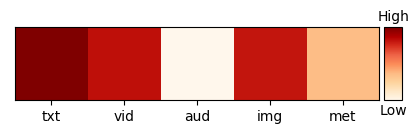

In [271]:
example_modality_dist = correct_modality_dist[example_id][np.newaxis, ...]/np.sum(correct_modality_dist[example_id])

fig = plt.figure()
fig.set_size_inches(5,5)
ax = fig.add_subplot(111)

img = plt.imshow(example_modality_dist, cmap='OrRd')
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_yticks([])
ax.set_xticks(np.arange(len(modality_xticks)))
ax.set_xticklabels(modality_xticks);

# Adjust colorbar size to match figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
# Remove minor ticks in colorbar
cbar.set_ticks([])
# Add text labels at top and bottom of colorbar
cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
    va='top', ha='center')
cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
    va='bottom', ha='center');

In [272]:
metadata_cols = ['movie_title',
                'cast_total_facebook_likes',
                'duration',
                'facenumber_in_poster',
                'director_name',
                'actor_1_name',
                'actor_2_name',
                'actor_3_name',
                'language',
                'num_critic_for_reviews',
                'movie_facebook_likes',
                'content_rating',
                'num_voted_users']

metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']].loc[metadata_cols]

movie_title                           Trapeze 
cast_total_facebook_likes                  986
duration                                   105
facenumber_in_poster                         0
director_name                       Carol Reed
actor_1_name                 Gina Lollobrigida
actor_2_name                       Katy Jurado
actor_3_name                      Sidney James
language                               English
num_critic_for_reviews                      20
movie_facebook_likes                       283
content_rating                        Approved
num_voted_users                           3102
Name: 3899, dtype: object

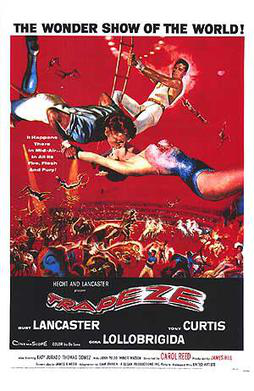

In [273]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

In [262]:
metadata_df['num_voted_users'].mean()

83668.16081697402

In [274]:
correct_modality_dist[example_id]

array([427, 417, 367, 416, 389])

#### Get example where plot had the min frequency

In [275]:
example_id = get_extreme_index("txt", np.argmin, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 3015,
 'synopsis': "The film closely follows Bly's original account, and extracts much of the dialogue from Bly’s 1880s expose Ten Days in a Mad-House. In an interview on Los Angeles talk radio, Caroline Barry recounts Christopher Lambert bringing authenticity to the part of the antagonist Dr. Dent, by portraying his motives as misguided good intent rather than evil. Which she feels adds to the realism of the biopic."}

In [276]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 66


In [277]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Timothy Hines
num_critic_for_reviews                                                       1
duration                                                                   111
director_facebook_likes                                                      0
actor_3_facebook_likes                                                     247
actor_2_name                                                     Kelly LeBrock
actor_1_facebook_likes                                                    1000
gross                                                                    14616
genres                                                                   Drama
actor_1_name                                               Christopher Lambert
movie_title                                             10 Days in a Madhouse 
num_voted_users                                     

In [278]:
modality_dist = correct_modality_dist[example_id][np.newaxis, ...]/np.sum(correct_modality_dist[example_id])

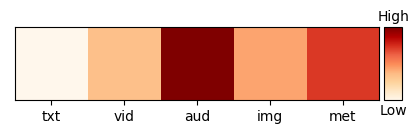

In [279]:
fig = plt.figure()
fig.set_size_inches(5,5)
ax = fig.add_subplot(111)

img = plt.imshow(modality_dist, cmap='OrRd')
modality_xticks = ['txt','vid','aud','img', 'met']
ax.set_yticks([])
ax.set_xticks(np.arange(len(modality_xticks)))
ax.set_xticklabels(modality_xticks);

# Adjust colorbar size to match figure
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(img, cax=cax)
# Remove minor ticks in colorbar
cbar.set_ticks([])
# Add text labels at top and bottom of colorbar
cbar.ax.text(0.5, -0.05, 'Low', transform=cbar.ax.transAxes, 
    va='top', ha='center')
cbar.ax.text(0.5, 1.05, 'High', transform=cbar.ax.transAxes, 
    va='bottom', ha='center');

In [280]:
metadata_cols = ['movie_title',
                'cast_total_facebook_likes',
                'duration',
                'facenumber_in_poster',
                'director_name',
                'actor_1_name',
                'actor_2_name',
                'actor_3_name',
                'language',
                'num_critic_for_reviews',
                'movie_facebook_likes',
                'content_rating',
                'num_voted_users']

metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']].loc[metadata_cols]

movie_title                  10 Days in a Madhouse 
cast_total_facebook_likes                      2059
duration                                        111
facenumber_in_poster                              1
director_name                         Timothy Hines
actor_1_name                    Christopher Lambert
actor_2_name                          Kelly LeBrock
actor_3_name                       Alexandra Callas
language                                    English
num_critic_for_reviews                            1
movie_facebook_likes                          26000
content_rating                                    R
num_voted_users                                 314
Name: 3015, dtype: object

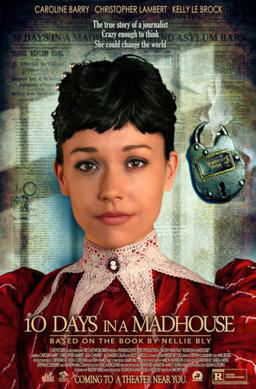

In [281]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

In [282]:
correct_modality_dist[example_id]

array([361, 380, 416, 385, 401])

### Poster

#### Get example where poster had the max frequency

In [271]:
example_id = get_extreme_index("img", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Comedy', 'Drama'],
 'id': 4744,
 'synopsis': 'Jim (Casey Affleck) is a perennially gloomy 27-year-old aspiring writer from Goshen, Indiana who had moved to New York City in hopes of finding success with his writing. After two years of barely making a living as a dog walker, he decides to move back home to his parents\' house in Goshen. Jim\'s 32-year-old brother Tim (Kevin Corrigan) is a recently divorced father of two young girls whose business recently failed. Tim has moved back into his parents\' home and works in the ladder factory that\'s owned and operated by their father Don (Seymour Cassel) and cheerful mother Sally (Mary Kay Place). Jim has no interest in the family business and he resists pressure from Don to start working there. Jim meets Anika (Liv Tyler), a nurse, in a bar and they end up having sex in a hospital bed, though Jim finishes almost immediately. After a conversation between the two brothers on whose life is more pathetic, Tim, having previously made

In [272]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 610


In [273]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Steve Buscemi
num_critic_for_reviews                                                      81
duration                                                                    91
director_facebook_likes                                                  12000
actor_3_facebook_likes                                                     213
actor_2_name                                                    Seymour Cassel
actor_1_facebook_likes                                                     778
gross                                                                   154077
genres                                                            Comedy|Drama
actor_1_name                                                    Kevin Corrigan
movie_title                                                      Lonesome Jim 
num_voted_users                                     

In [275]:
correct_modality_dist[example_id]

array([419, 417, 382, 426, 395])

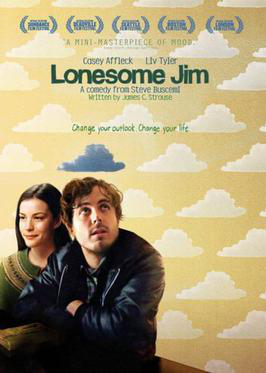

In [287]:
from IPython.display import display
from PIL import Image

poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

#### Get example where poster had the min frequency

In [288]:
example_id = get_extreme_index("img", np.argmin, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 3015,
 'synopsis': "The film closely follows Bly's original account, and extracts much of the dialogue from Bly’s 1880s expose Ten Days in a Mad-House. In an interview on Los Angeles talk radio, Caroline Barry recounts Christopher Lambert bringing authenticity to the part of the antagonist Dr. Dent, by portraying his motives as misguided good intent rather than evil. Which she feels adds to the realism of the biopic."}

In [289]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 66


In [290]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Timothy Hines
num_critic_for_reviews                                                       1
duration                                                                   111
director_facebook_likes                                                      0
actor_3_facebook_likes                                                     247
actor_2_name                                                     Kelly LeBrock
actor_1_facebook_likes                                                    1000
gross                                                                    14616
genres                                                                   Drama
actor_1_name                                               Christopher Lambert
movie_title                                             10 Days in a Madhouse 
num_voted_users                                     

In [291]:
correct_modality_dist[example_id]

array([361, 380, 416, 385, 401])

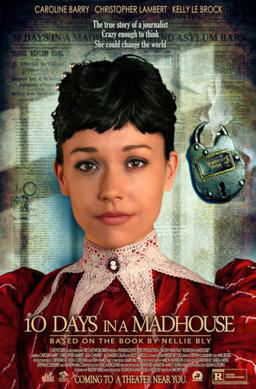

In [292]:
poster_id = str(data_labels[correct_indexes[example_id]]['id'])
display(Image.open('/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id+'.jpg'))

### Metadata

#### Get example where metadata had the max frequency

In [549]:
example_id = get_extreme_index("met", np.argmax, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Comedy', 'Family', 'Fantasy', 'Horror'],
 'id': 815,
 'synopsis': 'Zach Cooper and his mother Gale move to the town of Madison, Delaware. While settling in, Zach meets his new neighbor Hannah and her overprotective father "Mr. Shivers." Zach and Hannah become quick friends, but Mr. Shivers warns Zach to stay on his side of the fence. At Madison High School where Gale works as the vice-principal, Zach befriends Champ, a socially awkward student. Later that evening, Hannah comes to Zach and takes him to an abandoned amusement park out in the woods where they watch the sun set together on top of the Ferris wheel. When they get back home, Mr. Shivers appears and again warns Zach to stay away from them or something bad would happen. The next night, Zach hears Mr. Shivers and Hannah arguing, followed by Hannah screaming and something crashing. Zach calls the police, but Mr. Shivers assures the officers that the noise came from his television. Fearing Hannah is in danger, Zach tri

In [550]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 919


In [551]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Rob Letterman
num_critic_for_reviews                                                     218
duration                                                                   103
director_facebook_likes                                                     11
actor_3_facebook_likes                                                     543
actor_2_name                                                    Dylan Minnette
actor_1_facebook_likes                                                    2000
gross                                                              8.00217e+07
genres                                  Adventure|Comedy|Family|Fantasy|Horror
actor_1_name                                                        Odeya Rush
movie_title                                                        Goosebumps 
num_voted_users                                     

In [552]:
correct_modality_dist[example_id]

array([406, 423, 389, 408, 413])

#### Get example where metadata had the min frequency

In [553]:
example_id = get_extreme_index("met", np.argmin, correct_modality_dist)
data_labels[correct_indexes[example_id]]

{'label': ['Drama'],
 'id': 4349,
 'synopsis': 'Chacun Sa Nuit explores the carnal interdependencies among a host of characters who live in a town in provincial France. At the center of it all is Pierre (Arthur Dupont), a conceited and vain bisexual musician in his late teens who acts as a magnet, to varying degrees, for a whole array of characters - from his sister, Lucie (Lizzie Brocheré), with whom he has a heated incestuous relationship, to a city councilor with whom he participates in gay orgies. When Pierre turns up dead, Lucie investigates the reasons for his demise and charts the network of sadomasochistic relationships that crisscross the town.'}

In [554]:
print(f"Plot length: {len(data_labels[correct_indexes[example_id]]['synopsis'].split(' '))}")

Plot length: 103


In [555]:
metadata_df.iloc[data_labels[correct_indexes[example_id]]['id']]

color                                                                    Color
director_name                                                    Pascal Arnold
num_critic_for_reviews                                                      14
duration                                                                    95
director_facebook_likes                                                      0
actor_3_facebook_likes                                                     164
actor_2_name                                                   Lizzie Brocheré
actor_1_facebook_likes                                                     533
gross                                                                    18435
genres                                                                   Drama
actor_1_name                                                   Karl E. Landler
movie_title                                                    One to Another 
num_voted_users                                     

In [556]:
correct_modality_dist[example_id]

array([410, 412, 396, 422, 363])

### Get K highest or K lowest example index activatons per modality

In [173]:
def get_k_extreme_index(modality_name, k, func, modality_dist):
    modality_txt2idx = {'txt': 0,'vid': 1,'aud': 2,'img': 3, 'met': 4}
    
    if func == 'max':
        return modality_dist[:, modality_txt2idx[modality_name]].argsort()[-k:][::-1]
    elif func == 'min':
        return modality_dist[:, modality_txt2idx[modality_name]].argsort()[:k]

### Plot

#### Get k example where plot had min frequency

In [174]:
k_plot_lowest = get_k_extreme_index('txt', 10, 'min', correct_modality_dist)

In [175]:
correct_indexes[k_plot_lowest]

array([548, 897,  21, 575, 459, 867,  26, 948, 593, 531])

In [181]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_plot_lowest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_plot_lowest])}")

Mean plot len: 402.8
Mean plot std: 399.12649623897437


In [182]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_plot_lowest]

[66, 118, 125, 29, 50, 676, 125, 935, 855, 1049]

In [183]:
data_labels[correct_indexes[k_plot_lowest[0]]]['synopsis']

"The film closely follows Bly's original account, and extracts much of the dialogue from Bly’s 1880s expose Ten Days in a Mad-House. In an interview on Los Angeles talk radio, Caroline Barry recounts Christopher Lambert bringing authenticity to the part of the antagonist Dr. Dent, by portraying his motives as misguided good intent rather than evil. Which she feels adds to the realism of the biopic."

#### Get k example where plot had max frequency

In [800]:
k_plot_highest = get_k_extreme_index('txt', 10, 'max', correct_modality_dist)

In [801]:
correct_indexes[k_plot_highest]

array([874, 711,  23, 808,  28, 285, 528, 171, 136, 562])

In [802]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_plot_highest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_plot_highest])}")

Mean plot len: 399.1
Mean plot std: 223.15261593806153


In [803]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_plot_highest]

[185, 64, 505, 120, 631, 369, 737, 610, 249, 521]

### Audio

#### Get k example where audio had min frequency

In [804]:
k_audio_lowest = get_k_extreme_index('aud', 10, 'min', correct_modality_dist)

In [805]:
correct_indexes[k_audio_lowest]

array([278, 711, 897, 874, 808,  23, 285, 171,  21, 243])

In [806]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_audio_lowest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_audio_lowest])}")

Mean plot len: 314.6
Mean plot std: 265.53086449601295


In [807]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_audio_lowest]

[139, 64, 118, 185, 120, 505, 369, 610, 125, 911]

#### Get k example where audio had max frequency

In [808]:
k_audio_highest = get_k_extreme_index('aud', 10, 'max', correct_modality_dist)

In [809]:
correct_indexes[k_audio_highest]

array([856, 548, 310, 815, 269,  62,  40, 562, 978, 691])

In [810]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_audio_highest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_audio_highest])}")

Mean plot len: 346.0
Mean plot std: 364.32403159824634


In [811]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_audio_highest]

[105, 66, 63, 114, 134, 617, 472, 521, 1260, 108]

In [812]:
set(correct_indexes[k_audio_highest]).intersection(set(correct_indexes[k_plot_lowest]))

{548}

### Video

#### Get k example where video had min frequency

In [813]:
k_vid_lowest = get_k_extreme_index('vid', 10, 'min', correct_modality_dist)

In [814]:
correct_indexes[k_vid_lowest]

array([548, 346,  21, 137, 459, 897, 345, 815,  76,  26])

In [815]:
k_vid_lowest_idx = correct_indexes[k_vid_lowest]

In [816]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_vid_lowest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_vid_lowest])}")

Mean plot len: 209.5
Mean plot std: 238.69405103604907


In [817]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_vid_lowest]

[66, 449, 125, 840, 50, 118, 190, 114, 18, 125]

#### Get k example where vid had max frequency

In [818]:
k_vid_highest = get_k_extreme_index('vid', 10, 'max', correct_modality_dist)

In [819]:
correct_indexes[k_vid_highest]

array([808, 650,  13, 867, 948,  23, 403, 124, 531, 593])

In [820]:
k_vid_highest_idx = correct_indexes[k_vid_highest]

In [821]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_vid_highest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_vid_highest])}")

Mean plot len: 632.6
Mean plot std: 322.74981022457627


In [822]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_vid_highest]

[120, 686, 919, 676, 935, 505, 543, 38, 1049, 855]

### Metadata

#### Get k example where metadata had min frequency

In [823]:
k_met_lowest = get_k_extreme_index('met', 10, 'min', correct_modality_dist)

In [824]:
correct_indexes[k_met_lowest]

array([949, 345,  21, 459, 874, 897, 575, 877, 198, 691])

In [825]:
k_met_lowest_idx = correct_indexes[k_met_lowest]

In [826]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_met_lowest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_met_lowest])}")

Mean plot len: 130.3
Mean plot std: 96.1998440747177


In [827]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_met_lowest]

[103, 190, 125, 50, 185, 118, 29, 369, 26, 108]

In [845]:
def attr_list(idx_list, col_name):
    list_vals = []

    for idx in idx_list:
        val = metadata_df.iloc[data_labels[idx]['id']].loc[col_name]
        if not np.isnan(val):
            list_vals.append(val)
    
    return list_vals

In [857]:
attr_vals = attr_list(k_met_lowest_idx, 'num_critic_for_reviews')

print(f"Mean: {np.mean(attr_vals)}\nStd: {np.std(attr_vals)}")

Mean: 33.44444444444444
Std: 23.176190421834555


In [858]:
attr_vals = attr_list(k_met_lowest_idx, 'cast_total_facebook_likes')

print(f"Mean: {np.mean(attr_vals)}\nStd: {np.std(attr_vals)}")

Mean: 1265.8
Std: 1324.7277305167277


#### Get k example where metadata had max frequency

In [828]:
k_met_highest = get_k_extreme_index('met', 10, 'max', correct_modality_dist)

In [829]:
correct_indexes[k_met_highest]

array([ 13, 593, 867, 650,  55, 948, 124, 531, 919, 460])

In [830]:
k_met_highest_idx = correct_indexes[k_met_highest]

In [831]:
print(f"Mean plot len: {np.mean([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_met_highest])}")
print(f"Mean plot std: {np.std([len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_met_highest])}")

Mean plot len: 719.1
Mean plot std: 287.1057122385412


In [832]:
[len(data_labels[correct_indexes[idx]]['synopsis'].split(' ')) for idx in k_met_highest]

[919, 855, 676, 686, 488, 935, 38, 1049, 567, 978]

In [859]:
attr_vals = attr_list(k_met_highest_idx, 'num_critic_for_reviews')

print(f"Mean: {np.mean(attr_vals)}\nStd: {np.std(attr_vals)}")

Mean: 233.3
Std: 135.53084519768925


In [860]:
attr_vals = attr_list(k_met_highest_idx, 'cast_total_facebook_likes')

print(f"Mean: {np.mean(attr_vals)}\nStd: {np.std(attr_vals)}")

Mean: 12588.4
Std: 16186.202631871382


## Visualizing MulT cross-modal attention weights

In [283]:
import torch

In [ ]:
mult_weights_ = torch.load('model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run/model_best.pt')['state_dict']

from collections import OrderedDict
mult_weights = OrderedDict()
for k, v in mult_weights_.items():
    name = k[7:]
    mult_weights[name] = v

In [739]:
num_layer = '4'
layer_name = 'trans_v_with_l.layers'
att_weights = {k:v for k,v in mult_weights.items() if 'in_proj_weight' in k and num_layer in k}

In [740]:
att_weights.keys()

dict_keys(['trans_l_with_a.layers.4.self_attn.in_proj_weight', 'trans_l_with_v.layers.4.self_attn.in_proj_weight', 'trans_v_with_l.layers.4.self_attn.in_proj_weight', 'trans_v_with_a.layers.4.self_attn.in_proj_weight', 'trans_a_with_l.layers.4.self_attn.in_proj_weight', 'trans_a_with_v.layers.4.self_attn.in_proj_weight', 'trans_l_mem.layers.4.self_attn.in_proj_weight', 'trans_v_mem.layers.4.self_attn.in_proj_weight', 'trans_a_mem.layers.4.self_attn.in_proj_weight'])

In [741]:
#att_weights['module.trans_l_with_v.layers.'+num_layer+'.self_attn.in_proj_weight'].shape
att_weights[f'{layer_name}.'+num_layer+'.self_attn.in_proj_weight'].shape

torch.Size([2304, 768])

In [742]:
lv_weight = att_weights[f'{layer_name}.'+num_layer+'.self_attn.in_proj_weight']

In [743]:
lv_q_weight = la_weight[:768, :]
lv_k_weight = la_weight[768:768*2, :]

#### Load trained model

In [754]:
from mmbt.models.mmtr import MMTransformerGMU5MoviescopeClf
import torch.nn as nn

In [755]:
args = torch.load('model_save_mmtr/moviescope_VideoTextAudioPosterMetaGMUSeed5_mmtr_model_run/args.pt')

In [756]:
model = MMTransformerGMU5MoviescopeClf(args)
model.load_state_dict(mult_weights)
model.eval();

In [757]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[1].detach()
    return hook

In [758]:
num_layer = '4'

model.trans_l_with_v.layers[4].self_attn.register_forward_hook(get_activation(f'trans_l_with_v.layers.'+num_layer+'.self_attn'));
model.trans_l_with_a.layers[4].self_attn.register_forward_hook(get_activation(f'trans_l_with_a.layers.'+num_layer+'.self_attn'));
model.trans_v_with_l.layers[4].self_attn.register_forward_hook(get_activation(f'trans_v_with_l.layers.'+num_layer+'.self_attn'));
model.trans_v_with_a.layers[4].self_attn.register_forward_hook(get_activation(f'trans_v_with_a.layers.'+num_layer+'.self_attn'));
model.trans_a_with_l.layers[4].self_attn.register_forward_hook(get_activation(f'trans_a_with_l.layers.'+num_layer+'.self_attn'));
model.trans_a_with_v.layers[4].self_attn.register_forward_hook(get_activation(f'trans_a_with_v.layers.'+num_layer+'.self_attn'));

#### Load test data

In [749]:
import os
import torch
import torchvision.transforms as transforms
from pytorch_pretrained_bert import BertTokenizer
from torch.utils.data import DataLoader
from mmbt.data.dataset import JsonlDataset
from mmbt.data.vocab import Vocab
from mmbt.data.helpers import collate_fn

In [750]:
tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=True).tokenize
model_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.46777044, 0.44531429, 0.40661017],
                std=[0.12221994, 0.12145835, 0.14380469],
            ),
        ]
    )

test_set = JsonlDataset(
    os.path.join(args.data_path, args.task, "test.jsonl"),
    tokenizer,
    model_transforms,
    args.vocab,
    args,
)

In [766]:
%matplotlib inline
def show(img, txt_tokens, row_srt=0, row_end=None, col_srt=0, col_end=None):
    npimg = img.numpy()
    
    if row_end is None:
        row_end = npimg.shape[0]
    if col_end is None:
        col_end = npimg.shape[1]
    
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.imshow(npimg[row_srt:row_end, col_srt:col_end], interpolation='nearest')
    #plt.yticks(range(row_srt, row_end), txt_tokens[row_srt:row_end])
    #plt.xticks(range(col_srt, col_end), txt_tokens[col_srt:col_end])
    #plt.xticks(rotation = 45) 
    plt.tight_layout()
    #fig.savefig('lv_att.png')

#### Forward - Highest video

In [767]:
txt, segment, mask, img, tgt, audio, poster, metadata = collate_fn([test_set[k_vid_highest_idx[0]]], args)
out = model(txt, mask, segment, img, audio, poster, metadata)

txt_tokens = ids2tokens(txt.detach().squeeze(0).numpy())

layer_name = 'trans_v_with_l.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([200, 156])

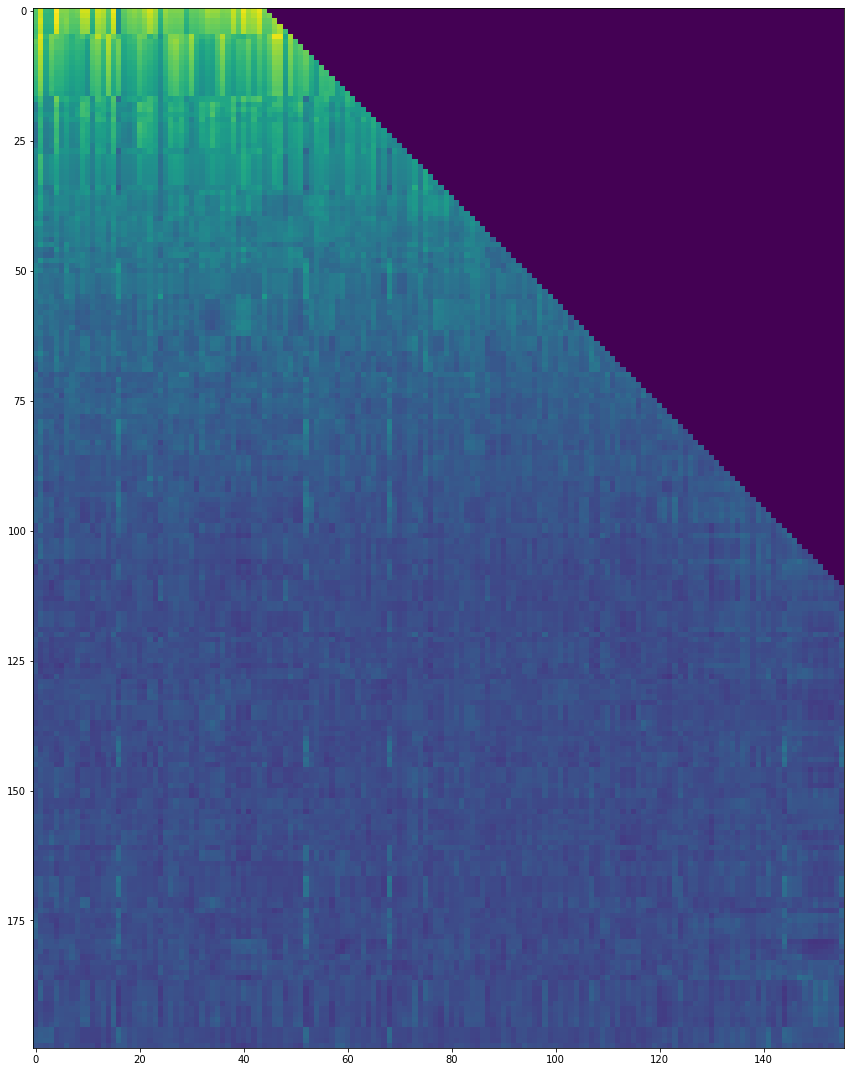

In [768]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)
#show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens, row_srt=0, row_end=200, col_srt=0, col_end=30)

In [769]:
layer_name = 'trans_l_with_v.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([156, 200])

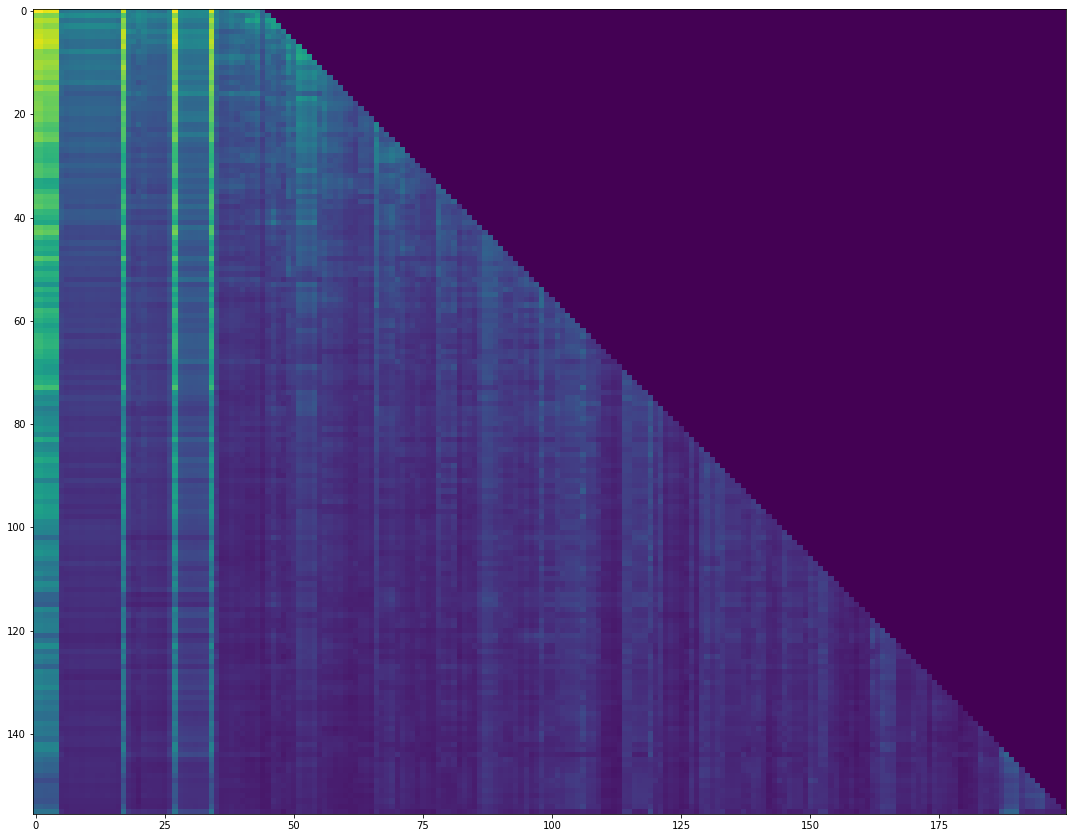

In [770]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)

In [771]:
layer_name = 'trans_a_with_v.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([200, 200])

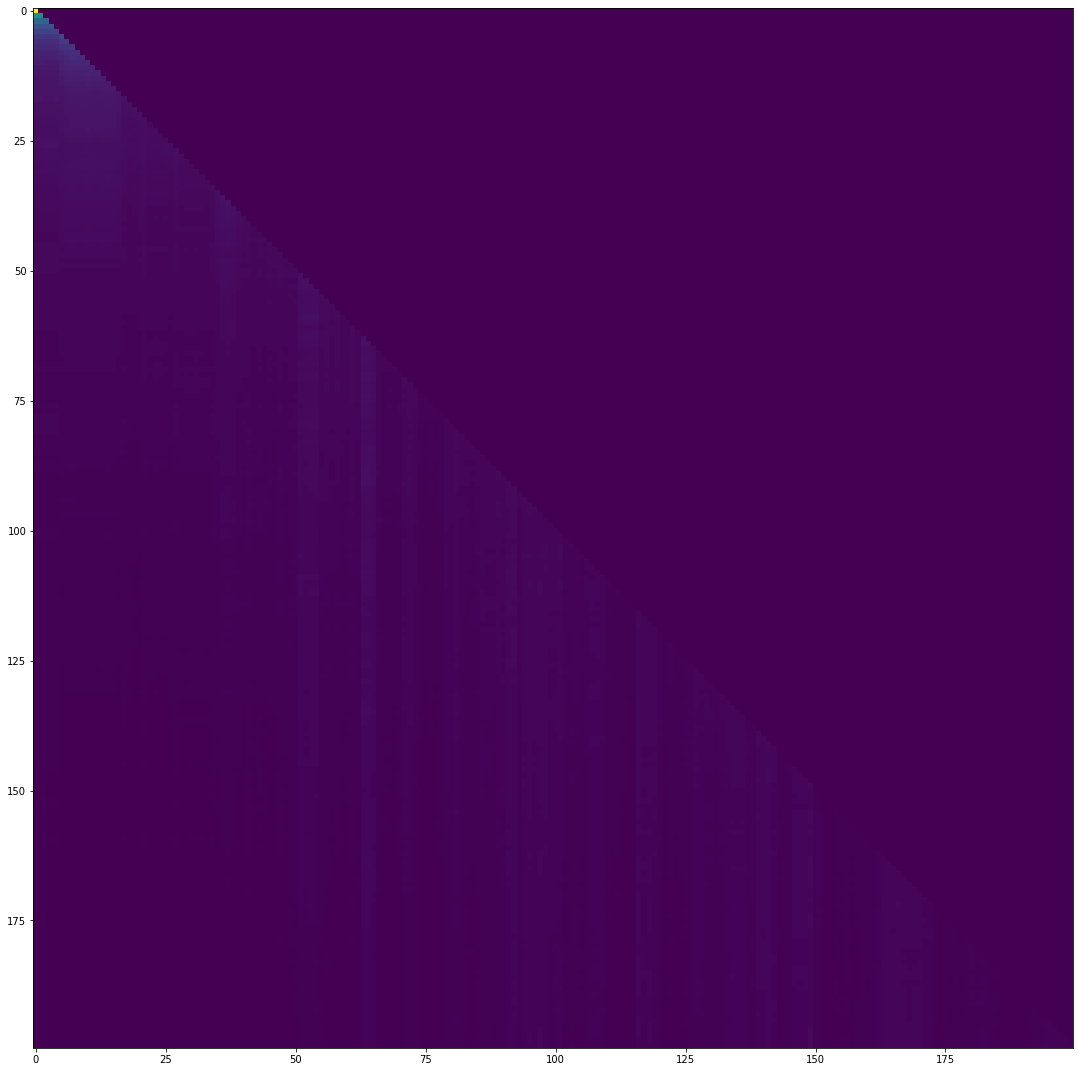

In [772]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)

In [773]:
layer_name = 'trans_a_with_l.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([200, 156])

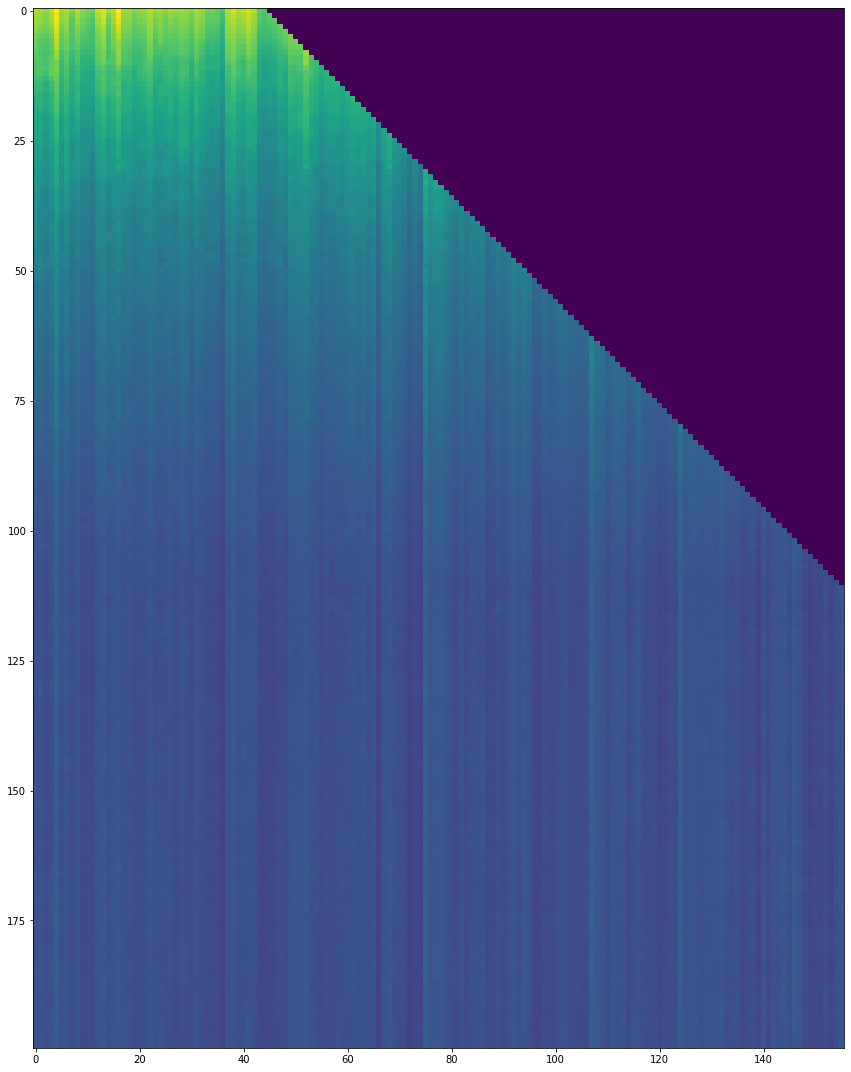

In [774]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)

#### Forward 2nd Highest video

In [775]:
activation = {}
txt, segment, mask, img, tgt, audio, poster, metadata = collate_fn([test_set[k_vid_highest_idx[1]]], args)
out = model(txt, mask, segment, img, audio, poster, metadata)

txt_tokens = ids2tokens(txt.detach().squeeze(0).numpy())

layer_name = 'trans_v_with_l.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([200, 512])

In [776]:
layer_name = 'trans_l_with_v.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([512, 200])

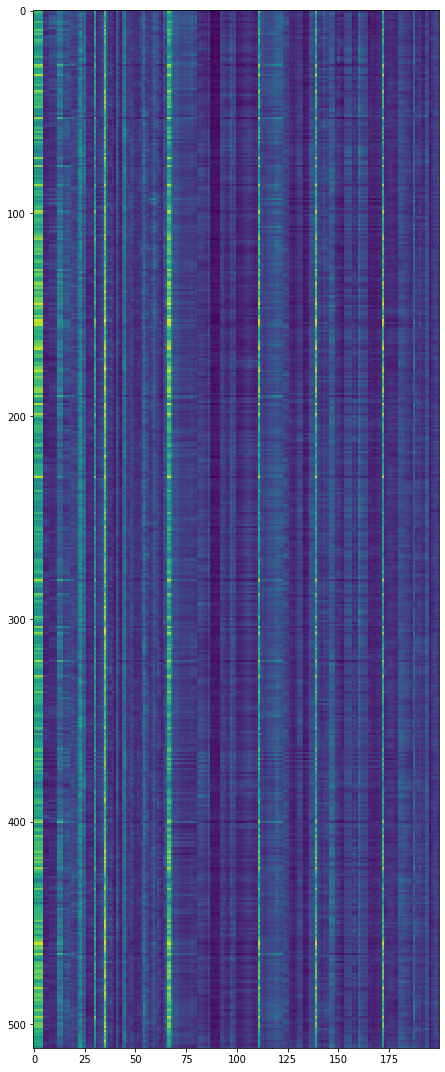

In [777]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)

In [778]:
layer_name = 'trans_v_with_l.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([200, 512])

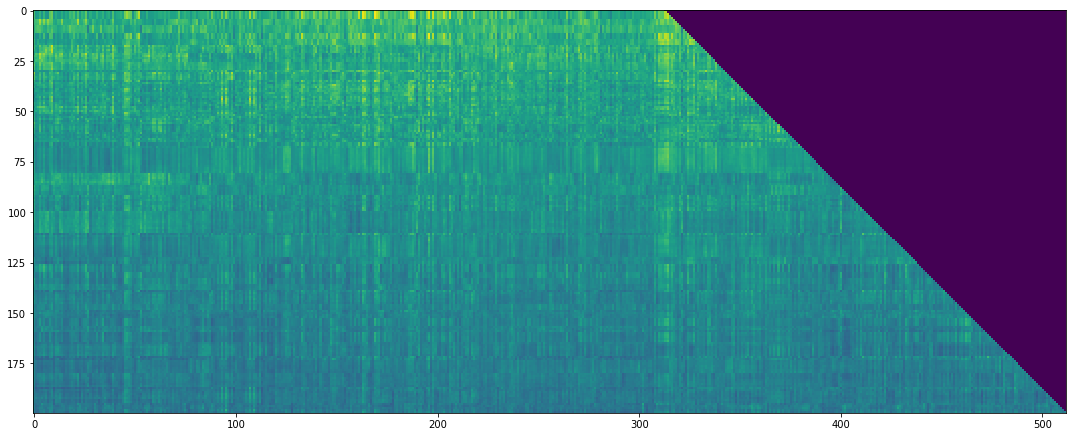

In [779]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)

#### Forward - Lowest video

In [780]:
activation = {}
txt, segment, mask, img, tgt, audio, poster, metadata = collate_fn([test_set[k_vid_lowest_idx[0]]], args)
out = model(txt, mask, segment, img, audio, poster, metadata)

txt_tokens = ids2tokens(txt.detach().squeeze(0).numpy())

layer_name = 'trans_v_with_l.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([200, 85])

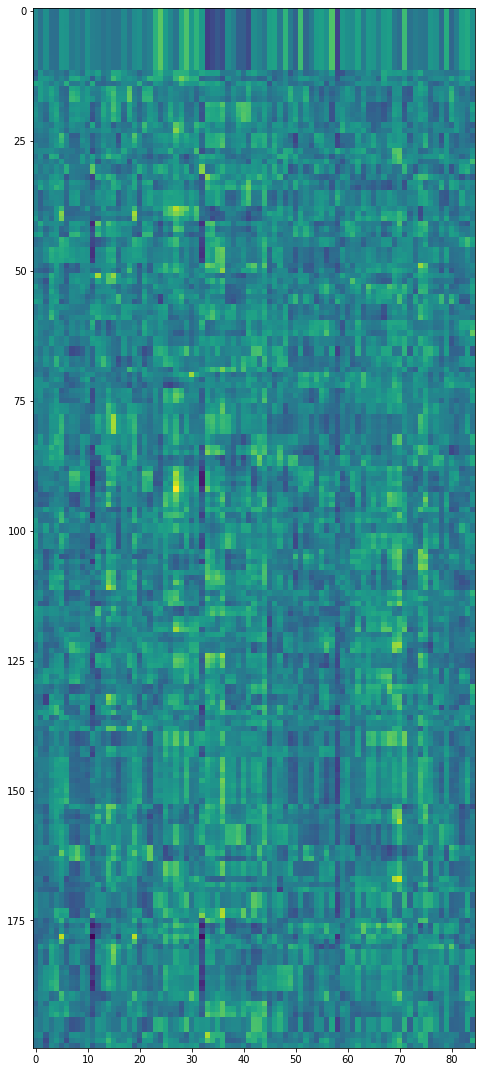

In [781]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)
#show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens, row_srt=0, row_end=200, col_srt=0, col_end=30)

In [784]:
layer_name = 'trans_l_with_v.layers'
activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0).shape

torch.Size([85, 200])

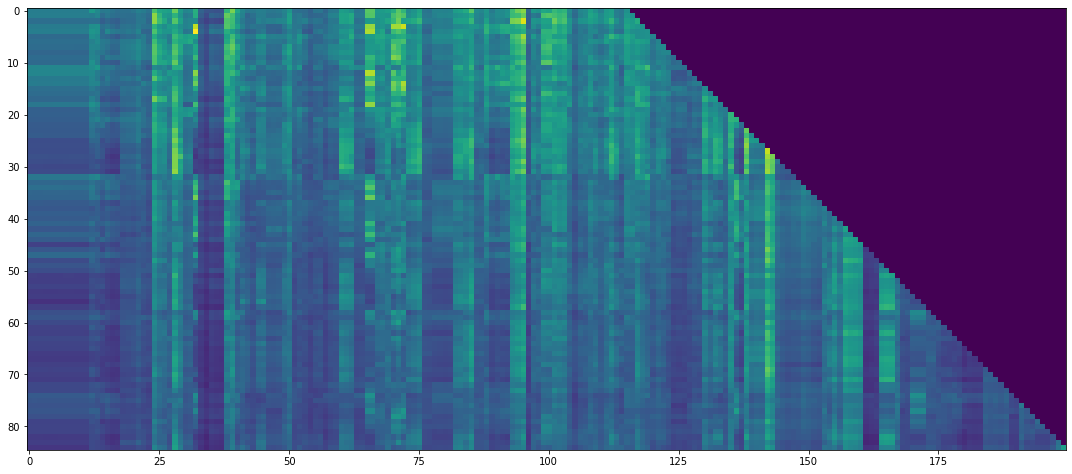

In [785]:
show(activation[f'{layer_name}.'+num_layer+'.self_attn'].squeeze(0), txt_tokens)

#### Load example

In [348]:
example_id = '4161'

In [ ]:
'/001/usuarios/isaac.bribiesca/moviescope/Raw_Poster/'+poster_id